## Visualize and analyse results from synthetic data experiments

In [1]:
import math, time
import torch
import os
import sys
sys.path.append('../..')
from functions.get_data import data_n_loaders
import matplotlib.pyplot as plt

In [2]:
#get exptnames from folder names within saved_models
def get_exptnames():
    exptnames = []
    for root, dirs, files in os.walk('saved_models'):
        for dir in dirs:
            if 'checkpoints_' in dir:
                exptnames.append(dir.split('checkpoints_')[1])
    #sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
    order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
    exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))
    return exptnames
#get sae_types from expt_names: it will be the string after first _, except for spade, which should be repaced by sparsemax_dist
def get_sae_types(exptnames):
    sae_types = []
    for exptname in exptnames:
        if 'spade' in exptname:
            sae_types.append('sparsemax_dist')
        elif 'topk_relu' in exptname:
            sae_types.append('topk_relu')
        else:
            sae_types.append(exptname.split('_')[1])
    return sae_types
#for each exptname, go into saved_models/checkpoints_exptname and save the largest #epochs in model_#epochs.pt

def get_max_epochs(exptnames):
    max_epochs = []
    for exptname in exptnames:
        epochs = []
        for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
            for file in files:
                if 'model_' in file:
                    epochs.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
        max_epochs.append(max(epochs))
    return max_epochs

In [3]:
exptnames = get_exptnames()
saetypes = get_sae_types(exptnames)
max_epochs = get_max_epochs(exptnames)
max_epochs = torch.tensor(max_epochs)
kvals_all = torch.zeros((len(exptnames),), dtype=int)
for i in range(len(exptnames)):
    if saetypes[i] == 'topk_relu':
        kvals_all[i] = int(exptnames[i].split('_k')[1].split('_')[0])
    else:
        kvals_all[i] = 0
kvals_all = kvals_all.tolist()

gammavals_all = []
for i in range(len(exptnames)):
    if saetypes[i] == 'topk_relu':
        gammavals_all.append(0.0)
    else:
        gamma = float(exptnames[i].split('_gamreg')[1].split('_')[0])
        gammavals_all.append(gamma)

In [4]:
gammavals_relu = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
gammavals_jumprelu = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 1.0]
gammavals_spade = [0.001, 0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
kvals_topk = [4, 8, 16, 32, 64, 128, 256]

indices_relux = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu]
indices_jumprelux = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu]
indices_topkx = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_topk]
indices_spadex = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade]

indices_all = indices_relux + indices_jumprelux + indices_topkx + indices_spadex

exptnames = [exptnames[i] for i in indices_all]
max_epochs = max_epochs[indices_all]
saetypes = [saetypes[i] for i in indices_all]
kvals_all = [kvals_all[i] for i in indices_all]
gammavals_all = [gammavals_all[i] for i in indices_all]

In [5]:
from models import SAE
dim = 128

import numpy as np

device = 'cuda'
modelsall = []
width = 512 #standard in this expt set
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True 
    modeli = SAE(dim, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_epochs[i]}epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli.to(device))

/tmp/ipykernel_1795581/2568957937.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_epochs[i]}

In [6]:
LAB_DIR = os.environ['USERDIR']
DATA_PATH = LAB_DIR+'/data'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

torch.manual_seed(0)

numpoints_perconcept = 1000
num_concepts = 5
batchsize = 2048

latent_reps_all = []
Cdatacos = []
stableranks = []

meannorm2_concepts_all = []
accuracies_perconcept_all = []
accuracies_all = []

mse_perconcept_all = torch.zeros((len(exptnames),num_concepts))
nmse_perconcept_all = torch.zeros((len(exptnames),num_concepts))
mse_all = torch.zeros((len(exptnames),))
nmse_all = torch.zeros((len(exptnames),))

mse_center = torch.zeros((len(exptnames), num_concepts))
datavars = torch.zeros((num_concepts,))

l0_perconcept_all = []
l0_all = []

dataset = f'128dgaussian_intrinsicdim'

_,_,train_data, _ = data_n_loaders(dataset, batchsize, return_data=True, \
                                    data_path=DATA_PATH, standardise_data = True)
#sample equal number of points from each class

data_subset_perconcept = []
labels_subset_perconcept = []
for j in range(num_concepts):
    indices = train_data.labels == j
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data.data[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset = torch.cat(data_subset_perconcept, dim=0)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)
meannorm2_concepts = torch.stack([torch.mean(torch.norm(data_subset[labels_subset==j,:], dim=1)**2) for j in range(num_concepts)])
meannorm2_concepts_all.append(meannorm2_concepts)

X_train, X_test, y_train, y_test = train_test_split(data_subset, labels_subset, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0, penalty='l2').fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
accuracies_all.append(acc)
#get acc per class
acc_perclass = torch.zeros((num_concepts,))
for j in range(num_concepts):
    indices = y_test == j
    acc_perclass[j] = accuracy_score(y_test[indices], y_pred[indices])
accuracies_perconcept_all.append(acc_perclass)


for k in range(num_concepts):
    datavars[k] = torch.var(data_subset[labels_subset==k,:], dim=0).sum()

for i in range(len(exptnames)):
    modeli = modelsall[i]
    with torch.no_grad():
        
        preds, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        mse_persample = torch.sum((preds - data_subset.to(device))**2, dim=-1)
        mse_perconcept_all[i,:] = torch.stack([torch.mean(mse_persample[labels_subset==j]) for j in range(num_concepts)])
        nmse_perconcept_all[i,:] = mse_perconcept_all[i,:]/meannorm2_concepts
        mse_all[i] = torch.mean(mse_persample)
        nmse_all[i] = mse_all[i]/torch.mean(torch.norm(data_subset, dim=1)**2)
        
        #mse wrt mean of each concept
        for k in range(num_concepts):
            center_k = data_subset[labels_subset==k,:].mean(dim=0, keepdim=True).to(device)
            mse_center[i,k] = (preds[labels_subset==k,:]-center_k).pow(2).sum(dim=-1).mean()
            
            

        latentsflat = latent_reps.flatten()
        active = latentsflat>1e-12
        if active.sum()>0:
            # threshold = torch.quantile(latentsflat[active], 0.01)
            threshold = 1e-6
            activelatentdist = (latent_reps>threshold).float().sum(dim=1)
            # activelatentdist_all.append(activelatentdist)
            l0_perconcept = torch.stack([torch.mean(activelatentdist[labels_subset==j]) for j in range(num_concepts)])
            l0_perconcept_all.append(l0_perconcept)
            l0_all.append(torch.mean(activelatentdist))
        else:
            # activelatentdist_all.append(torch.zeros((latent_reps_all[i].shape[0],)))
            l0_perconcept_all.append(torch.zeros((num_concepts,)))
            l0_all.append(torch.tensor([0.0]))


        latent_reps_all.append(latent_reps)
        Cdata = latent_reps @ latent_reps.T
        
        norms = torch.norm(latent_reps, dim=1).unsqueeze(1)
        Cdatacos.append(Cdata/(norms @ norms.T + 1e-12))
        print(f"Finished {exptnames[i]}")

/n/home00/sumedh/spmax_sae/experiments/expt16_intrinsicdimX/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)


Finished tip482_relu_gamreg0.01_021425
Finished quick804_relu_gamreg0.001_021425
Finished lever383_relu_gamreg1.0_021425
Finished sleep807_relu_gamreg0.05_021825
Finished prize339_relu_gamreg0.5_021825
Finished harp908_relu_gamreg0.1_021425
Finished hip180_relu_gamreg5.0_021425
Finished flume123_jumprelu_gamreg0.01_021425
Finished tart881_jumprelu_gamreg1.0_021425
Finished zoo703_jumprelu_gamreg0.001_021425
Finished math932_jumprelu_gamreg0.025_021825
Finished beg966_jumprelu_gamreg0.075_021825
Finished stove733_jumprelu_gamreg0.1_021425
Finished wheel477_jumprelu_gamreg0.05_021825
Finished oven615_topk_relu_k4_021425
Finished lid221_topk_relu_k16_021425
Finished kill672_topk_relu_k64_021425
Finished will922_topk_relu_k32_021425
Finished bulb185_topk_relu_k8_021425
Finished shear233_topk_relu_k256_021425
Finished grade476_topk_relu_k128_021425
Finished start658_spade_gamreg0.1_021425
Finished reply209_spade_gamreg5.0_021425
Finished radio678_spade_gamreg0.01_021425
Finished barn475_spa

In [8]:
f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))
eps = 1e-12
for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)

ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

In [11]:
f1_sorted.shape

torch.Size([28, 5, 512])

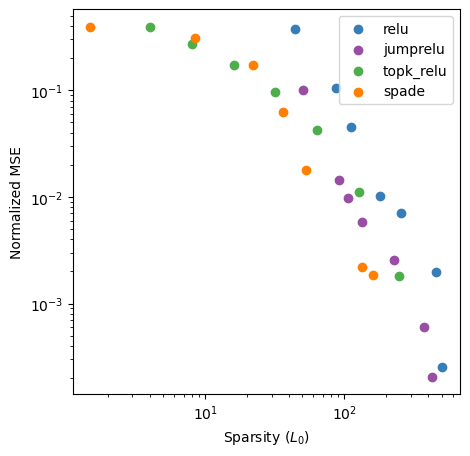

In [12]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}
# alpha_scale = scales/max(scales)
# accuracies_all = torch.tensor(accuracies_all)
# alpha_perf = accuracies_all - accuracies_all.min()
# alpha_perf = alpha_perf/(alpha_perf.max())
# alpha_perf = torch.exp(accuracies_all)/(torch.exp(accuracies_all).max())

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(exptnames)):
    if i%7==6:
        label = saetypes[i] if saetypes[i] != 'sparsemax_dist' else 'spade'
    else:
        label = None
    # if scales[i]==1.0:
    ax.scatter(l0_all[i].cpu(), nmse_all[i].cpu(), c=colors_saetypes[saetypes[i]], alpha=1, label=label)
ax.legend()
ax.set_xlabel(r'Sparsity ($L_0$)')
ax.set_ylabel(r'Normalized MSE')
ax.set_yscale('log')
ax.set_xscale('log')


plt.show()

In [13]:
indices_spade = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist']
indices_topk = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu']
indices_relu = [i for i in range(len(exptnames)) if saetypes[i] == 'relu']
indices_jumprelu = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu']

/tmp/ipykernel_1795581/3326693124.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l0_sorted, order = torch.sort(torch.tensor(l0_all)[ind])


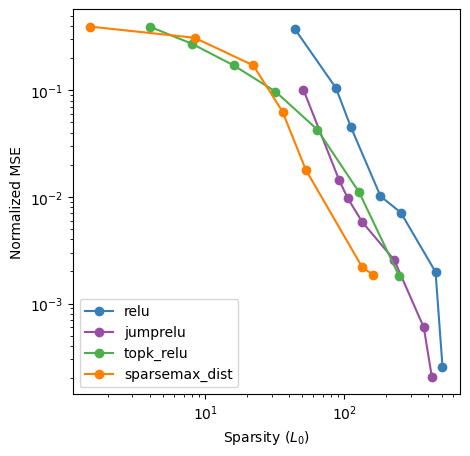

In [ ]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}
# alpha_scale = scales/max(scales)
# accuracies_all = torch.tensor(accuracies_all)
# alpha_perf = accuracies_all - accuracies_all.min()
# alpha_perf = alpha_perf/(alpha_perf.max())
# alpha_perf = torch.exp(accuracies_all)/(torch.exp(accuracies_all).max())

fig, ax = plt.subplots(figsize=(5, 5))


    # if scales[i]==1.0:
count = 0
saeorder = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']
for ind in [indices_relu, indices_jumprelu, indices_topk, indices_spade]:
    l0_sorted, order = torch.sort(torch.tensor(l0_all)[ind])
    order = order.squeeze()
    ax.plot(l0_sorted.cpu(), nmse_all[ind][order].cpu(), c=colors_saetypes[saeorder[count]], marker='o', linestyle='solid', label=saeorder[count])
    count+=1
ax.legend()
ax.set_xlabel(r'Sparsity ($L_0$)')
ax.set_ylabel(r'Normalized MSE')
ax.set_yscale('log')
ax.set_xscale('log')


plt.show()

In [15]:
intrinsic_dims = train_data.truefeatures['intrinsic_dims']

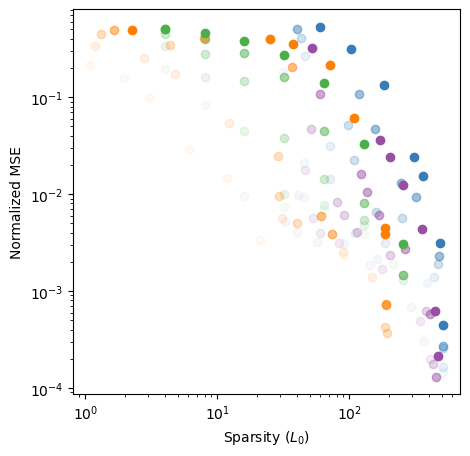

In [16]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(figsize=(5, 5))
for j in range(num_concepts):
    for i in range(len(exptnames)):
        if j==0:
            label = saetypes[i] if i%7==6 else None
        else:
            label = None
        ax.scatter(l0_perconcept_all[i][j].cpu(), nmse_perconcept_all[i][j].cpu(), \
            c=colors_saetypes[saetypes[i]], alpha=float(intrinsic_dims[j]/intrinsic_dims.max()), label=label)
    
    # ax.set_title("Dim= "+str(intrinsic_dims[j].item()))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Sparsity ($L_0$)')
ax.set_ylabel(r'Normalized MSE')
fig.show()

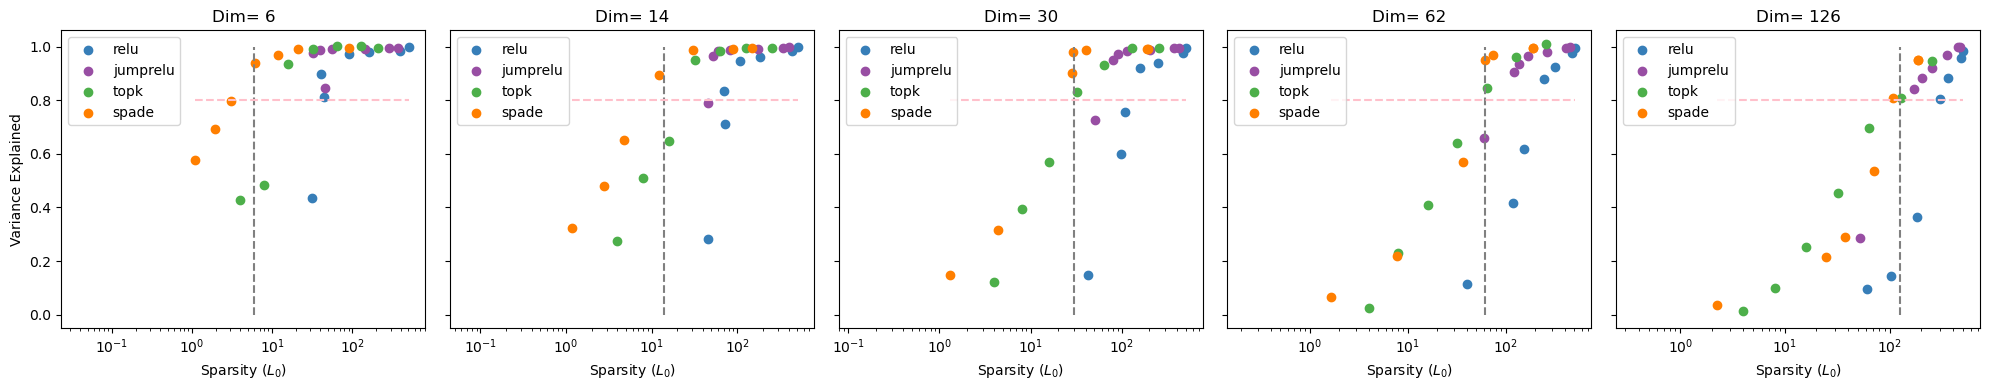

In [17]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    
    for i in range(len(exptnames)):
        label = saetypes[i] if i%7==6 else None
        if label=='sparsemax_dist':
            label = 'spade'
        elif label=='topk_relu':
            label = 'topk'
        ax[j].scatter(l0_perconcept_all[i][j].cpu(), mse_center[i,j].cpu()/datavars[j], \
            c=colors_saetypes[saetypes[i]], alpha=1.0, label=label)
    # ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend()
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    if j==0:
        ax[j].set_ylabel(r'Variance Explained')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    ax[j].vlines(intrinsic_dims[j], 0, 1, linestyles='dashed', colors='gray')

    min_l0 = min([l0_perconcept_all[i][j].min().cpu() for i in range(len(exptnames))])
    max_l0 = max([l0_perconcept_all[i][j].max().cpu() for i in range(len(exptnames))])
    ax[j].hlines(0.8, min_l0, max_l0, colors='pink', linestyles='dashed')
fig.tight_layout()
fig.show()

In [18]:
l0_perconcept_all = [l0.cpu().numpy() for l0 in l0_perconcept_all]
l0_perconcept_all = torch.tensor(l0_perconcept_all)

/tmp/ipykernel_1795581/1598653744.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  l0_perconcept_all = torch.tensor(l0_perconcept_all)


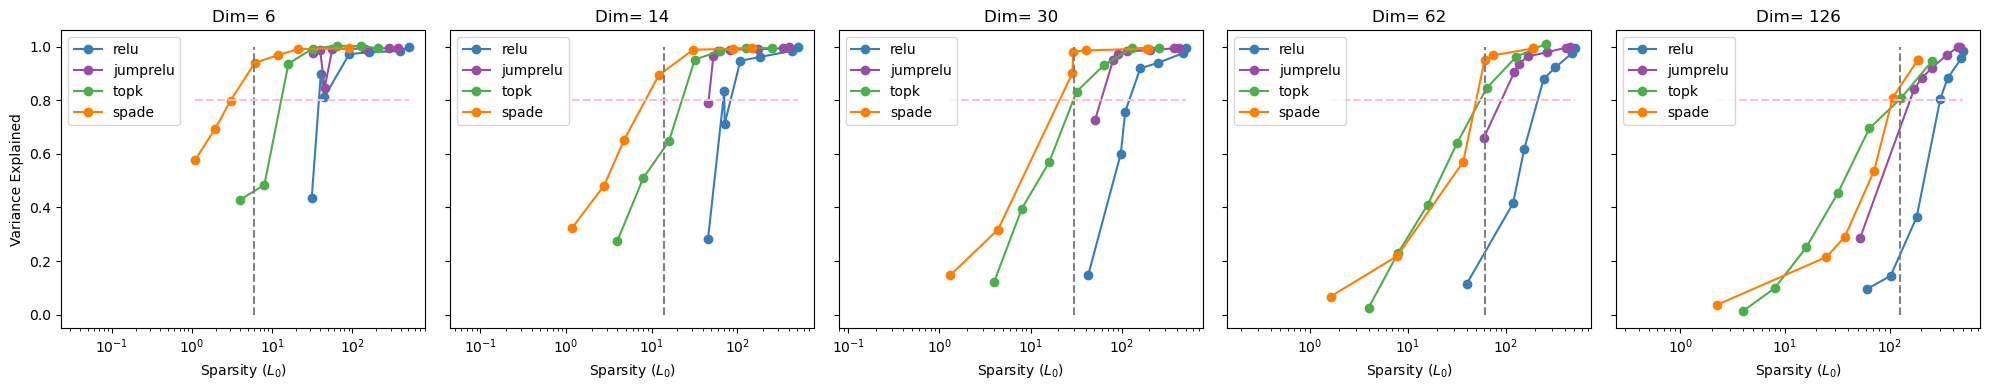

In [19]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    
    # for i in range(len(exptnames)):
    #     label = saetypes[i] if i%7==6 else None
    #     if label=='sparsemax_dist':
    #         label = 'spade'
    #     elif label=='topk_relu':
    #         label = 'topk'
    count = 0
    for ind in [indices_relu, indices_jumprelu, indices_topk, indices_spade]:
        l0vals = l0_perconcept_all[ind,j]
        l0vals_sorted, order = torch.sort(l0vals)
        label = saeorder[count]
        if label=='sparsemax_dist':
            label = 'spade'
        elif label=='topk_relu':
            label = 'topk'
        ax[j].plot(l0vals_sorted, mse_center[ind,j][order].cpu()/datavars[j], \
            c=colors_saetypes[saeorder[count]], alpha=1.0, marker='o', linestyle='solid', label=label)
        count+=1
    # ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend()
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    if j==0:
        ax[j].set_ylabel(r'Variance Explained')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    ax[j].vlines(intrinsic_dims[j], 0, 1, linestyles='dashed', colors='gray')

    min_l0 = min([l0_perconcept_all[i][j].min().cpu() for i in range(len(exptnames))])
    max_l0 = max([l0_perconcept_all[i][j].max().cpu() for i in range(len(exptnames))])
    ax[j].hlines(0.8, min_l0, max_l0, colors='pink', linestyles='dashed')
fig.tight_layout()
fig.show()

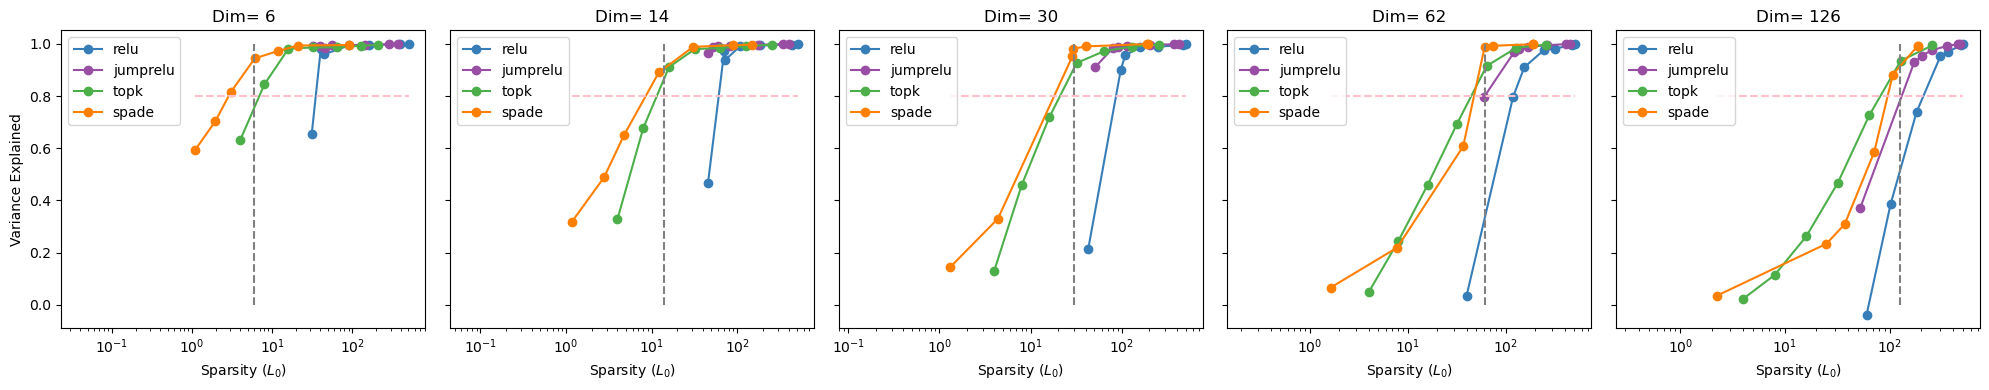

In [20]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    
    # for i in range(len(exptnames)):
    #     label = saetypes[i] if i%7==6 else None
    #     if label=='sparsemax_dist':
    #         label = 'spade'
    #     elif label=='topk_relu':
    #         label = 'topk'
    count = 0
    for ind in [indices_relu, indices_jumprelu, indices_topk, indices_spade]:
        l0vals = l0_perconcept_all[ind,j]
        l0vals_sorted, order = torch.sort(l0vals)
        label = saeorder[count]
        if label=='sparsemax_dist':
            label = 'spade'
        elif label=='topk_relu':
            label = 'topk'
        ax[j].plot(l0vals_sorted, 1.0- (mse_perconcept_all[ind,j][order].cpu()/datavars[j]), \
            c=colors_saetypes[saeorder[count]], alpha=1.0, marker='o', linestyle='solid', label=label)
        count+=1
    # ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend()
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    if j==0:
        ax[j].set_ylabel(r'Variance Explained')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    ax[j].vlines(intrinsic_dims[j], 0, 1, linestyles='dashed', colors='gray')

    min_l0 = min([l0_perconcept_all[i][j].min().cpu() for i in range(len(exptnames))])
    max_l0 = max([l0_perconcept_all[i][j].max().cpu() for i in range(len(exptnames))])
    ax[j].hlines(0.8, min_l0, max_l0, colors='pink', linestyles='dashed')
fig.tight_layout()
fig.show()

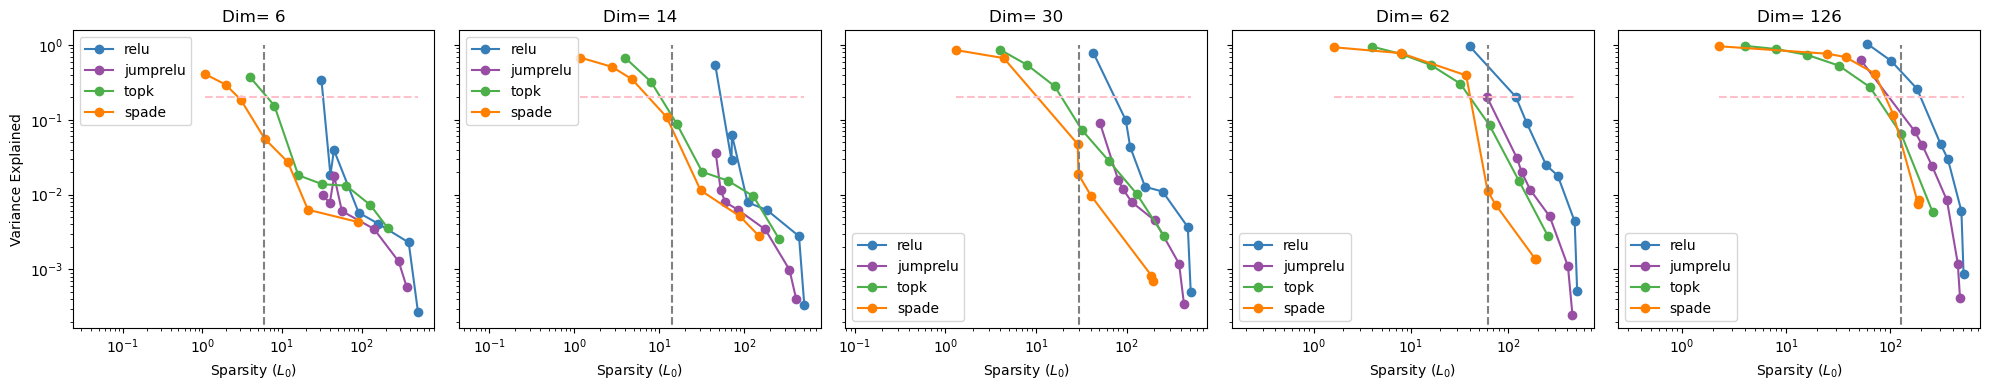

In [21]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    
    # for i in range(len(exptnames)):
    #     label = saetypes[i] if i%7==6 else None
    #     if label=='sparsemax_dist':
    #         label = 'spade'
    #     elif label=='topk_relu':
    #         label = 'topk'
    count = 0
    for ind in [indices_relu, indices_jumprelu, indices_topk, indices_spade]:
        l0vals = l0_perconcept_all[ind,j]
        l0vals_sorted, order = torch.sort(l0vals)
        label = saeorder[count]
        if label=='sparsemax_dist':
            label = 'spade'
        elif label=='topk_relu':
            label = 'topk'
        ax[j].plot(l0vals_sorted, (mse_perconcept_all[ind,j][order].cpu()/datavars[j]), \
            c=colors_saetypes[saeorder[count]], alpha=1.0, marker='o', linestyle='solid', label=label)
        count+=1
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend()
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    if j==0:
        ax[j].set_ylabel(r'Variance Explained')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    ax[j].vlines(intrinsic_dims[j], 0, 1, linestyles='dashed', colors='gray')

    min_l0 = min([l0_perconcept_all[i][j].min().cpu() for i in range(len(exptnames))])
    max_l0 = max([l0_perconcept_all[i][j].max().cpu() for i in range(len(exptnames))])
    ax[j].hlines(1-0.8, min_l0, max_l0, colors='pink', linestyles='dashed')
fig.tight_layout()
fig.show()

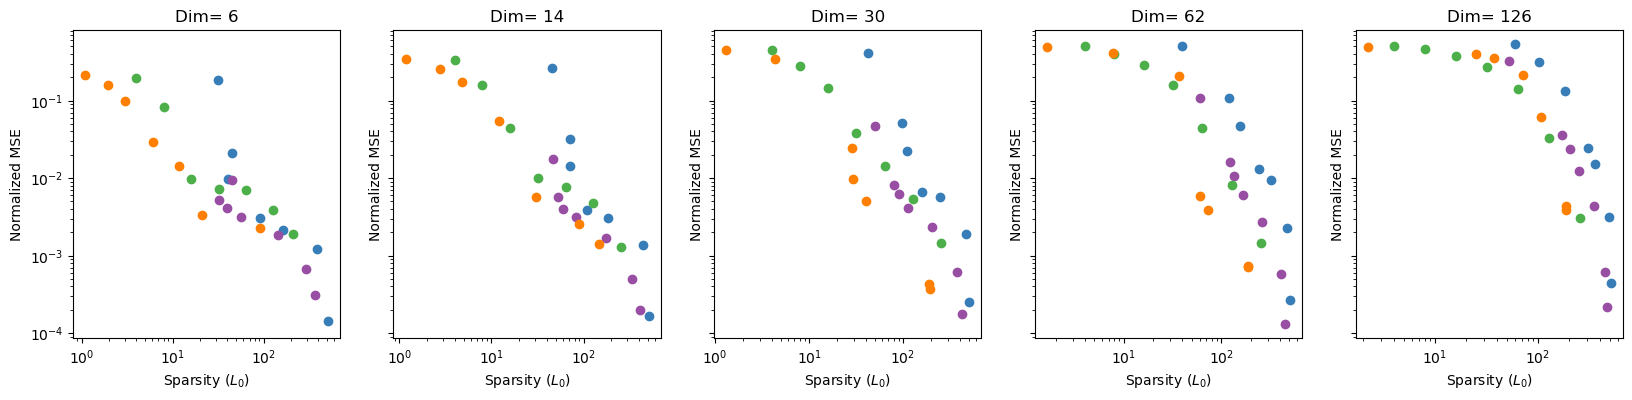

In [22]:
#plot nmse vs l0 for each concept in separate plot
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    for i in range(len(exptnames)):
        if j==0:
            label = saetypes[i] if i%7==6 else None
        else:
            label = None
        ax[j].scatter(l0_perconcept_all[i][j].cpu(), nmse_perconcept_all[i][j].cpu(), \
            c=colors_saetypes[saetypes[i]], alpha=1.0, label=label)
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    ax[j].set_ylabel(r'Normalized MSE')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    fig.show()

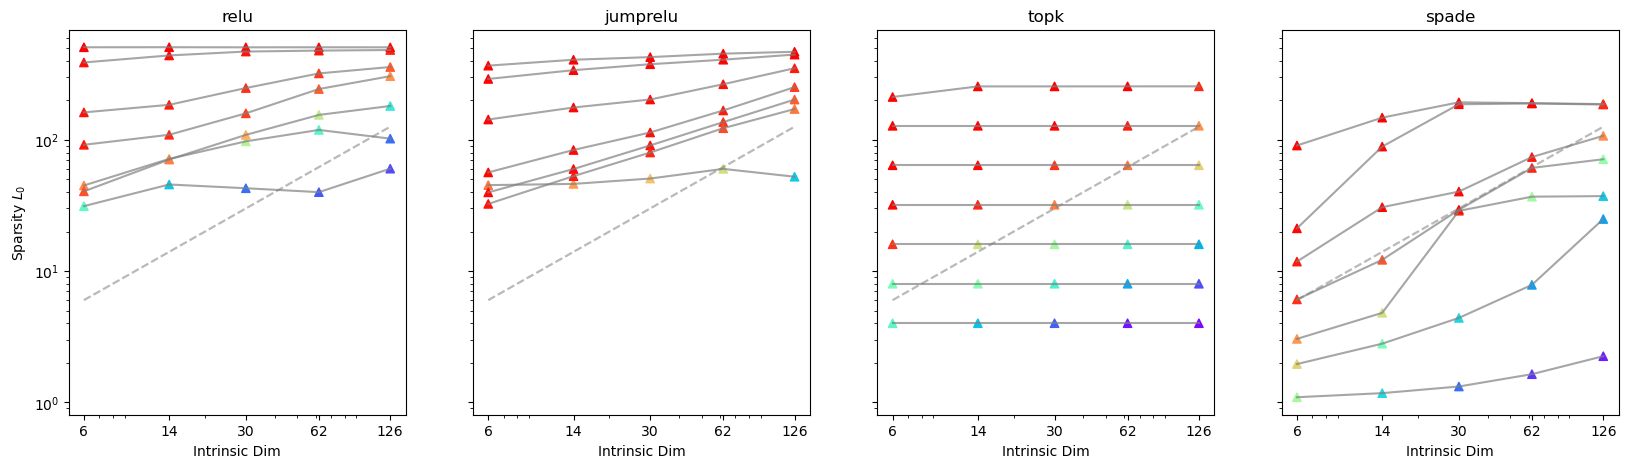

In [23]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}


cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)

for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    varex = mse_center[i, :].cpu() / datavars
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, l0_perconcept_all[i, :], color='gray', linestyle='solid', alpha=0.7)
    ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(intrinsic_dims, l0_perconcept_all[i, :], color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Intrinsic Dim')
    if plotid==0:
        ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    
    ax[plotid].set_yscale('log')
    ax[plotid].set_title(label)
plt.show()

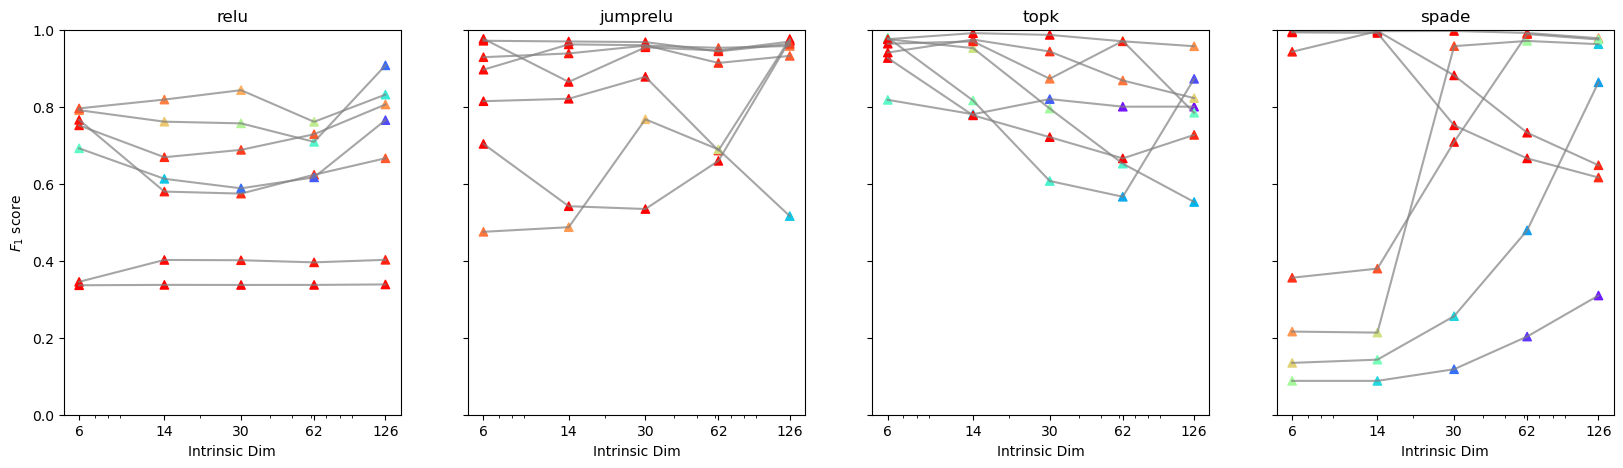

In [29]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}


cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)
shownum = 5
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    varex = mse_center[i, :].cpu() / datavars
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1), color='gray', linestyle='solid', alpha=0.7)
    std_f1 = f1_sorted[i, :, :shownum].std(dim=-1)
    # ax[plotid].fill_between(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1) - std_f1, 
                            # f1_sorted[i, :, :shownum].mean(dim=-1) + std_f1, color='gray', alpha=0.3)
    ax[plotid].scatter(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1), color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Intrinsic Dim')
    if plotid==0:
        ax[plotid].set_ylabel(r'$F_1$ score')
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    
    # ax[plotid].set_yscale('log')
    ax[plotid].set_title(label)
    ax[plotid].set_ylim(0, 1)
plt.show()

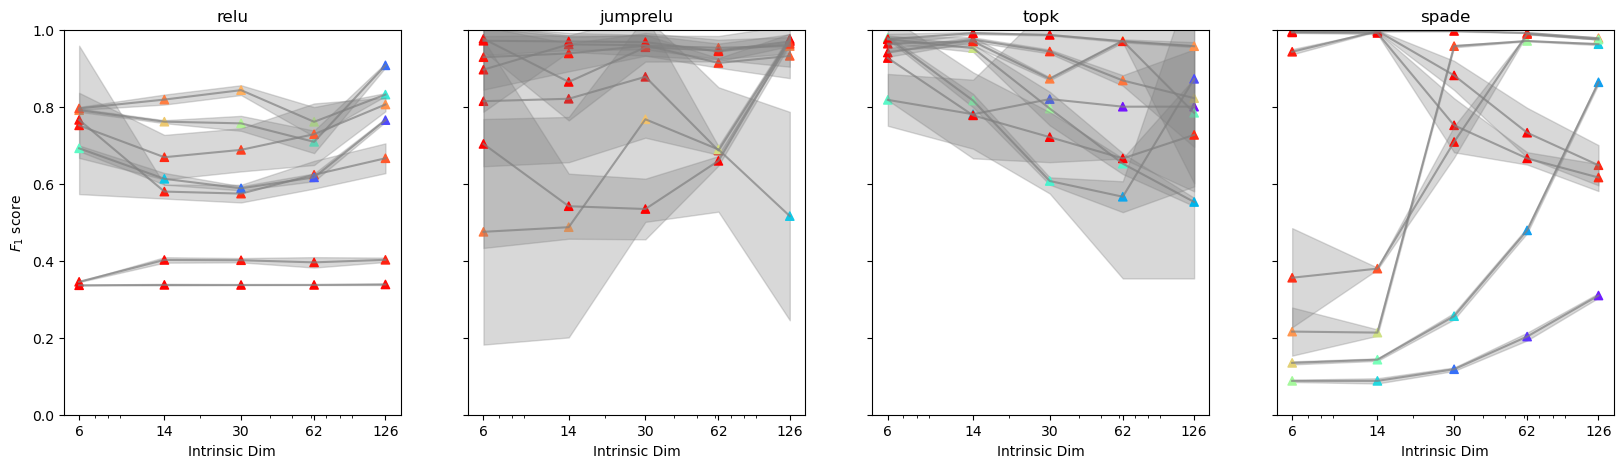

In [28]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}


cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)
shownum = 5
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    varex = mse_center[i, :].cpu() / datavars
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1), color='gray', linestyle='solid', alpha=0.7)
    std_f1 = f1_sorted[i, :, :shownum].std(dim=-1)
    ax[plotid].fill_between(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1) - std_f1, 
                            f1_sorted[i, :, :shownum].mean(dim=-1) + std_f1, color='gray', alpha=0.3)
    ax[plotid].scatter(intrinsic_dims, f1_sorted[i, :, :shownum].mean(dim=-1), color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Intrinsic Dim')
    if plotid==0:
        ax[plotid].set_ylabel(r'$F_1$ score')
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    
    # ax[plotid].set_yscale('log')
    ax[plotid].set_title(label)
    ax[plotid].set_ylim(0, 1)
plt.show()

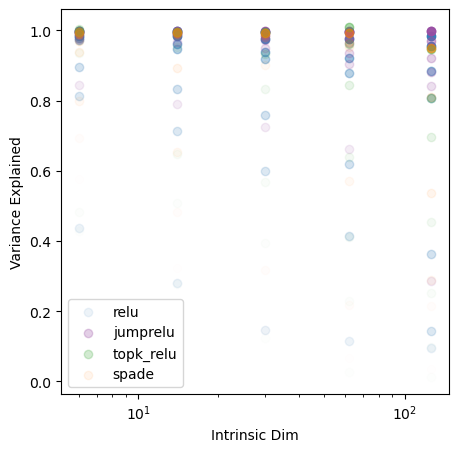

In [32]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

# alpha_l0 = 1/(1e-12+torch.tensor(l0_all))
alpha_l0 = torch.tensor(l0_all)
alpha_l0 = alpha_l0/(alpha_l0.max())
# alpha_l0 = alpha_l0/(alpha_l0[alpha_l0<1e10].max())
# alpha_l0 = alpha_l0 
# alpha_l0 = alpha_l0
# alpha_perf = torch.exp(accuracies_all)/(torch.exp(accuracies_all).max())

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(exptnames)):
    if i%7==6:
        label = saetypes[i] if saetypes[i] != 'sparsemax_dist' else 'spade'
    else:
        label = None
    # if scales[i]==1.0:
    if 'gamreg50' not in exptnames[i]:
        ax.scatter(intrinsic_dims, mse_center[i,:].cpu()/datavars, c=colors_saetypes[saetypes[i]], alpha=alpha_l0[i].item(), label=label)
ax.legend()
ax.set_xlabel(r'Intrinsic Dim')
ax.set_ylabel(r'Variance Explained')
# ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

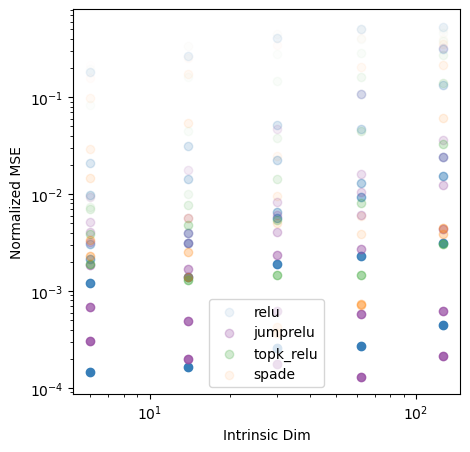

In [33]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

# alpha_l0 = 1/(1e-12+torch.tensor(l0_all))
alpha_l0 = torch.tensor(l0_all)
alpha_l0 = alpha_l0/alpha_l0.max()
# alpha_l0 = alpha_l0 
# alpha_l0 = alpha_l0
# alpha_perf = torch.exp(accuracies_all)/(torch.exp(accuracies_all).max())

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(exptnames)):
    if i%7==6:
        label = saetypes[i] if saetypes[i] != 'sparsemax_dist' else 'spade'
    else:
        label = None
    # if scales[i]==1.0:
    ax.scatter(train_data.truefeatures['intrinsic_dims'], nmse_perconcept_all[i,:].cpu(), c=colors_saetypes[saetypes[i]], alpha=alpha_l0[i].item(), label=label)
ax.legend()
ax.set_xlabel(r'Intrinsic Dim')
ax.set_ylabel(r'Normalized MSE')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [34]:
stableranks = []
for i in range(len(exptnames)):
    sr = torch.trace(Cdatacos[i])/torch.linalg.matrix_norm(Cdatacos[i], ord=2)
    stableranks.append(sr.item())

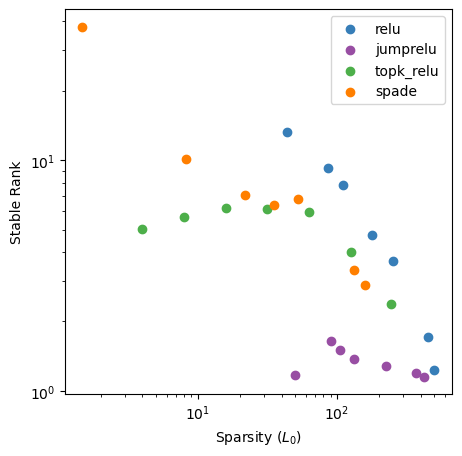

In [35]:
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}
# alpha_scale = scales/max(scales)
accuracies_all = torch.tensor(accuracies_all)
alpha_perf = accuracies_all - accuracies_all.min()
alpha_perf = alpha_perf/(alpha_perf.max())
# alpha_perf = torch.exp(accuracies_all)/(torch.exp(accuracies_all).max())

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(exptnames)):
    if i%7==6:
        label = saetypes[i] if saetypes[i] != 'sparsemax_dist' else 'spade'
    else:
        label = None
    # if scales[i]==1.0:
    ax.scatter(l0_all[i].cpu(), stableranks[i], c=colors_saetypes[saetypes[i]], alpha=1.0, label=label)
ax.legend()
ax.set_xlabel(r'Sparsity ($L_0$)')
ax.set_ylabel(r'Stable Rank')
ax.set_yscale('log')
ax.set_xscale('log')


plt.show()

In [36]:
gammvals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 5e0, 1e1]
kvalues_order = [256, 128, 64, 32, 16, 8, 4]
saes_order = ['relu', 'jumprelu', 'sparsemax_dist', 'topk_relu']

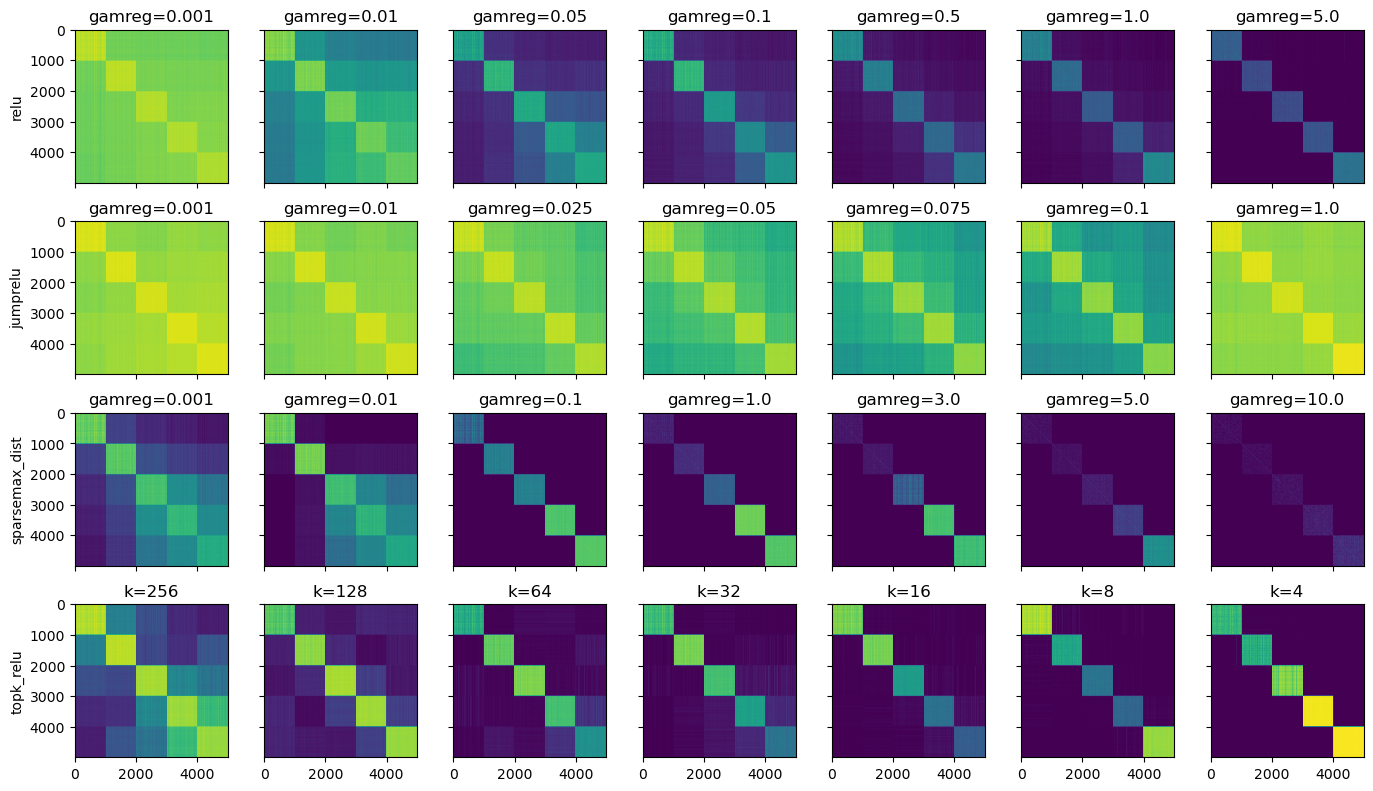

In [38]:
fig, ax = plt.subplots(len(set(saetypes)), 7, figsize=(14, 8), sharex=True, sharey=True)
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kvalues_oder = [256, 128, 64, 32, 16, 8, 4]
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    
    rowid = saes_order.index(saetypes[i])
    ax[rowid, loc].imshow(Cdatacos[i].cpu(), cmap='viridis', vmin=0, vmax=1)
    # ax[rowid, loc].set_title(exptnames[i])
    if loc==0:
        ax[rowid, 0].set_ylabel(saetypes[i])
    # if rowid==0:
    if saetypes[i]=='topk_relu':
        ax[rowid, loc].set_title(f"k={kval_i}")
    else:
        ax[rowid, loc].set_title(f"gamreg={gami}")

fig.tight_layout()
fig.show()

In [39]:
deadlatents_all = []
for i in range(len(exptnames)):
    if (latent_reps_all[i]>1e-12).sum()==0:
        deadlatents_all.append(torch.ones((latent_reps_all[i].shape[-1],), dtype=bool))
    else:
        threshold = torch.quantile(latent_reps_all[i][latent_reps_all[i]>0.0].flatten(), 0.1)
        # threshold = 1e-12
        deadlatents = torch.all(latent_reps_all[i] <= threshold, dim=0)
        deadlatents_all.append(deadlatents.cpu())

#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[0].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i][:, ~deadlatents_all[i]], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)


#sort latent representations by concept
latentreps_conceptsorted_all = []
for i in range(len(exptnames)):
    activelatents = ~deadlatents_all[i]
    latentsactive = latent_reps_all[i][:, activelatents]
    latentsactive_conceptsorted = latentsactive[:, order_by_concept_all[i]]
    latentsdead = latent_reps_all[i][:, ~activelatents]
    latents_sortedanddead = torch.cat([latentsactive_conceptsorted, latentsdead], dim=1)
    latentreps_conceptsorted_all.append(latents_sortedanddead) #reorder latents by concepts


#track co-occurrence of latents
Clatent = []
for i in range(len(exptnames)):
    Clatent.append(latentreps_conceptsorted_all[i].T @ latentreps_conceptsorted_all[i])

Clatent_cos = []
Clatent_cos_active = []
for i in range(len(exptnames)):
    norms = torch.norm(latentreps_conceptsorted_all[i], dim=0).unsqueeze(1)
    active_i = (norms>1e-12).squeeze()
    eps = 1e-6
    C = Clatent[i]/(eps+ (norms @ norms.T))
    Clatent_cos.append(C)
    C  = C[active_i,:]
    C = C[:, active_i]
    Clatent_cos_active.append(C)

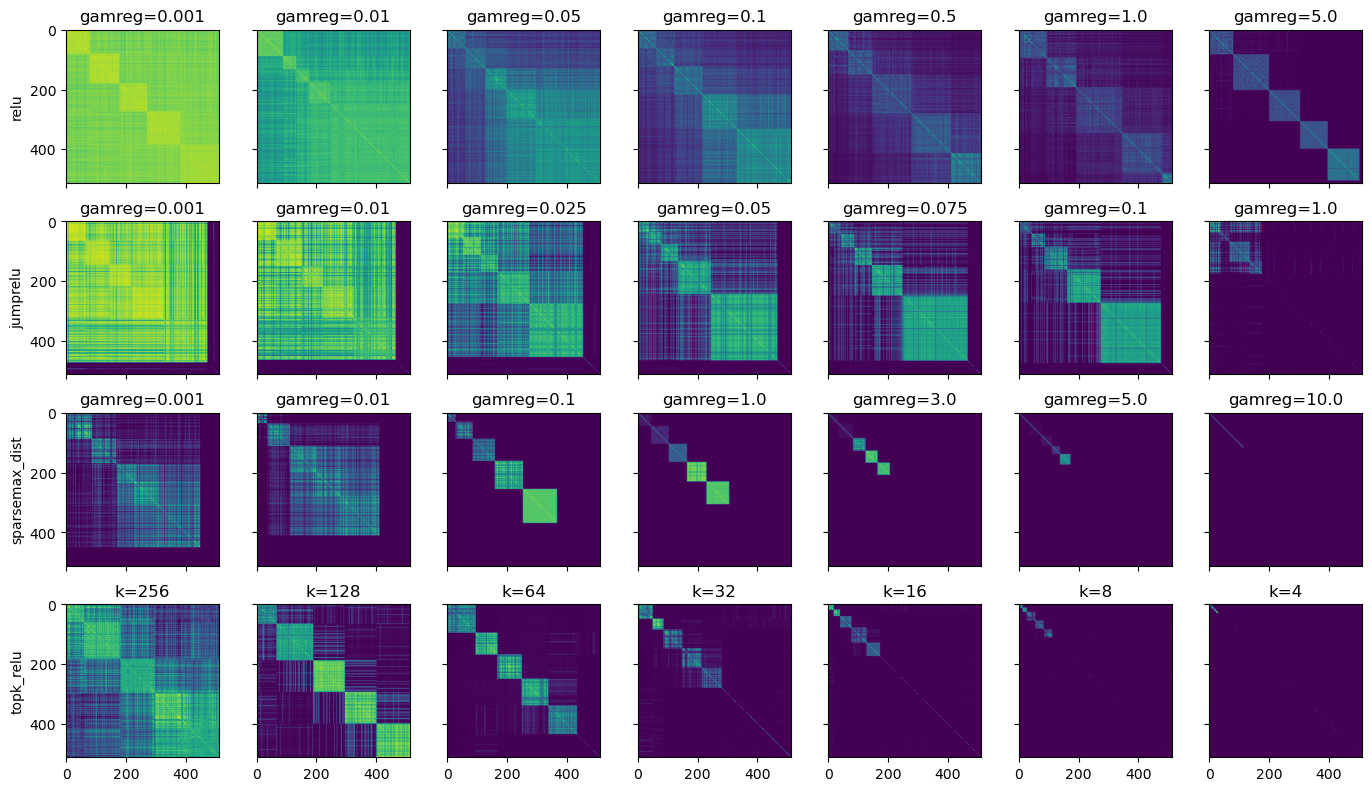

In [40]:
fig, ax = plt.subplots(len(set(saetypes)), 7, figsize=(14, 8), sharex=True, sharey=True)
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kvalues_oder = [256, 128, 64, 32, 16, 8, 4]
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    
    rowid = saes_order.index(saetypes[i])
    ax[rowid, loc].imshow(Clatent_cos[i].cpu(), cmap='viridis', vmin=0, vmax=1)
    # ax[rowid, loc].set_title(exptnames[i])
    if loc==0:
        ax[rowid, 0].set_ylabel(saetypes[i])
    # if rowid==0:
    if saetypes[i]=='topk_relu':
        ax[rowid, loc].set_title(f"k={kval_i}")
    else:
        ax[rowid, loc].set_title(f"gamreg={gami}")

fig.tight_layout()
fig.show()